In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# import tensorflow as tf
# tf.device('/gpu:3')

In [2]:
%load_ext autoreload

In [3]:
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

In [4]:
# from tensorflow.python.client import device_lib 
# print(device_lib.list_local_devices())

In [6]:
import os
import numpy as np
import nibabel as nib
import nibabel.orientations as nio
import matplotlib.pyplot as plt
from tqdm import tqdm
from data_utilities import *
import tensorflow as tf
from tensorflow import keras
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import load
import glob
import sys
import json
import time
from PIL import Image, ImageDraw
from pathlib import Path
import os
import shutil
import re
import zipfile

import matplotlib.pyplot as plt
import cv2

import numpy as np
import pickle

import nrrd
import pydicom as pdm

from tqdm import tqdm

import io
import base64
from IPython.display import HTML

In [7]:
# Loss Function and coefficients to be used during training:
def dice_coe(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.reshape(y_true,[-1])
    y_pred_f = tf.reshape(y_pred,[-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (2. * intersection + smooth) / (union + smooth)

In [8]:
def dice_loss(y_true,y_pred, loss_type='jaccard', smooth=1.):

    y_true_f = tf.cast(tf.reshape(y_true,[-1]),tf.float32)
    y_pred_f =tf.cast(tf.reshape(y_pred,[-1]),tf.float32)

    intersection = tf.reduce_sum(y_true_f * y_pred_f)

    if loss_type == 'jaccard':
        union = tf.reduce_sum(tf.square(y_pred_f)) + tf.reduce_sum(tf.square(y_true_f))

    elif loss_type == 'sorensen':
        union = tf.reduce_sum(y_pred_f) + tf.reduce_sum(y_true_f)

    else:
        raise ValueError("Unknown `loss_type`: %s" % loss_type)

    return (1-(2. * intersection + smooth) / (union + smooth))

In [8]:
activation = 'sigmoid'
patch_size_x =128 
patch_size_y =128 
patch_size_z =128
n_classes = 1
channels=1

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv3D, Input, MaxPooling3D, Dropout, concatenate, UpSampling3D, BatchNormalization
import tensorflow as tf

def Unet3D(inputs,num_classes):
    x=inputs
    conv1 = Conv3D(8, 3, activation = 'relu', padding = 'same',data_format="channels_last")(x)
    conv1= BatchNormalization()(conv1)
    conv1 = Conv3D(8, 3, activation = 'relu', padding = 'same')(conv1)
    conv1= BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)
    conv2 = Conv3D(16, 3, activation = 'relu', padding = 'same')(pool1)
    conv2= BatchNormalization()(conv2)
    conv2 = Conv3D(16, 3, activation = 'relu', padding = 'same')(conv2)
    conv2= BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)
    conv3 = Conv3D(32, 3, activation = 'relu', padding = 'same')(pool2)
    conv3= BatchNormalization()(conv3)
    conv3 = Conv3D(32, 3, activation = 'relu', padding = 'same')(conv3)
    conv3= BatchNormalization()(conv3)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)
    conv4 = Conv3D(64, 3, activation = 'relu', padding = 'same')(pool3)
    conv4= BatchNormalization()(conv4)
    conv4 = Conv3D(64, 3, activation = 'relu', padding = 'same')(conv4)
    conv4= BatchNormalization()(conv4)
    drop4 = Dropout(0.01)(conv4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)

    conv5 = Conv3D(128, 3, activation = 'relu', padding = 'same')(pool4)
    conv5= BatchNormalization()(conv5)
    conv5 = Conv3D(128, 3, activation = 'relu', padding = 'same')(conv5)
    conv5= BatchNormalization()(conv5)
    drop5 = Dropout(0.01)(conv5)

    up6 = Conv3D(64, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(drop5))
    up6= BatchNormalization()(up6)
    merge6 = concatenate([drop4,up6],axis=-1)
    conv6 = Conv3D(64, 3, activation = 'relu', padding = 'same')(merge6)
    conv6= BatchNormalization()(conv6)
    conv6 = Conv3D(64, 3, activation = 'relu', padding = 'same')(conv6)
    conv6= BatchNormalization()(conv6)

    up7 = Conv3D(32, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(conv6))
    up7= BatchNormalization()(up7)
    merge7 = concatenate([conv3,up7],axis=-1)
    conv7 = Conv3D(32, 3, activation = 'relu', padding = 'same')(merge7)
    conv7= BatchNormalization()(conv7)
    conv7 = Conv3D(32, 3, activation = 'relu', padding = 'same')(conv7)
    conv7= BatchNormalization()(conv7)

    up8 = Conv3D(16, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(conv7))
    up8= BatchNormalization()(up8)
    merge8 = concatenate([conv2,up8],axis=-1)
    conv8 = Conv3D(16, 3, activation = 'relu', padding = 'same')(merge8)
    conv8= BatchNormalization()(conv8)
    conv8 = Conv3D(16, 3, activation = 'relu', padding = 'same')(conv8)
    conv8= BatchNormalization()(conv8)

    up9 = Conv3D(8, 2, activation = 'relu', padding = 'same')(UpSampling3D(size = (2,2,2))(conv8))
    up9= BatchNormalization()(up9)
    merge9 = concatenate([conv1,up9],axis=-1)
    conv9 = Conv3D(8, 3, activation = 'relu', padding = 'same')(merge9)
    conv9= BatchNormalization()(conv9)
    conv9 = Conv3D(8, 3, activation = 'relu', padding = 'same')(conv9)
    conv9= BatchNormalization()(conv9)
#     conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)
    conv10 = Conv3D(1, 1, activation = 'sigmoid')(conv9)
    model = Model(inputs=inputs, outputs = conv10)
    #model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [10]:
inputs = tf.keras.Input(shape=(patch_size_x,patch_size_y,patch_size_z, channels))
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:2"]) 

# with mirrored_strategy.scope():
Model_3D = Unet3D(inputs,num_classes=n_classes)
Model_3D.compile(optimizer=optim, loss=dice_loss, metrics=[dice_coe])
    
    
Model_3D.summary()

2021-12-04 19:54:54.356113: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-12-04 19:54:54.400794: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:67:00.0 name: NVIDIA TITAN RTX computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2021-12-04 19:54:54.400997: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2021-12-04 19:54:54.402657: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-12-04 19:54:54.404213: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10
2021-12-04 19:54:54.404482: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 12 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 128, 128 224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 128 32          conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 1736        batch_normalization[0][0]        
______________________________________________________________________________________________

In [11]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K



def parse_image(img_path, image_size):
    image_rgb = np.load(img_path)
#     print(img_path)
    train_img=np.expand_dims(image_rgb, axis=3)
#     train_img = np.stack((image_rgb,)*3, axis=-1)
    return train_img

def parse_mask(mask_path, image_size):
    mask = np.load(mask_path)
    mask = np.where(mask==0,mask,1)
    train_mask = np.expand_dims(mask, axis=3)
    return train_mask


class DataGen(Sequence):
    def __init__(self, image_size, images_path, masks_path, batch_size=8):
        self.image_size = image_size
        self.images_path = images_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.on_epoch_end()

    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.images_path):
            self.batch_size = len(self.images_path) - index*self.batch_size

        images_path = self.images_path[index*self.batch_size : (index+1)*self.batch_size]
        masks_path = self.masks_path[index*self.batch_size : (index+1)*self.batch_size]

        images_batch = []
        masks_batch = []

        for i in range(len(images_path)):
            # Read image and mask
            image = parse_image(images_path[i], self.image_size)
            mask = parse_mask(masks_path[i], self.image_size)

            images_batch.append(image)
            mask=np.where(mask>1,1,mask)
            masks_batch.append(mask)

        return np.array(images_batch), np.array(masks_batch)

    def on_epoch_end(self):
        pass

    def __len__(self):
        return int(np.ceil(len(self.images_path)/float(self.batch_size)))
    

In [12]:
train_data_paths = sorted(glob.glob("total_crops/training/images/*.npy"))
train_masks_paths = sorted(glob.glob("total_crops/training/masks/*.npy"))



valid_data_paths = sorted(glob.glob("total_crops/validation/images/*.npy"))
valid_masks_paths = sorted(glob.glob("total_crops/validation/masks/*.npy"))

In [13]:
image_size = 128
batch_size = 1

epochs = 100

train_steps = len(train_data_paths)//batch_size
valid_steps = len(valid_data_paths)//batch_size

## Generator
train_gen = DataGen(image_size, train_data_paths,train_masks_paths, batch_size=batch_size)
valid_gen = DataGen(image_size,valid_data_paths, valid_masks_paths, batch_size=batch_size)

In [14]:
train_gen.__getitem__(20)[0].shape

(1, 128, 128, 128, 1)

In [15]:
history=Model_3D.fit(train_gen,
                            validation_data=valid_gen,epochs=200,shuffle=True
                              )

Epoch 1/200


2021-12-04 19:55:03.522698: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
2021-12-04 19:55:05.066177: E tensorflow/stream_executor/cuda/cuda_dnn.cc:329] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2021-12-04 19:55:05.088683: E tensorflow/stream_executor/cuda/cuda_dnn.cc:329] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model/conv3d/Conv3D (defined at tmp/ipykernel_5335/1123682859.py:1) ]] [Op:__inference_train_function_15086]

Function call stack:
train_function


In [16]:
Model_3D.save('/home/minha/AIDA/3Dunet_model_200epochs_complete.h5')

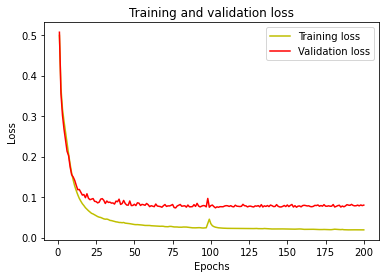

In [17]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

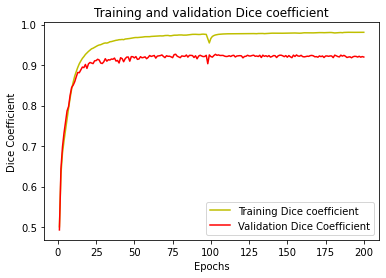

In [18]:
acc = history.history['dice_coe']
val_acc = history.history['val_dice_coe']

plt.plot(epochs, acc, 'y', label='Training Dice coefficient')
plt.plot(epochs, val_acc, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()

In [19]:
def compute_dice(im1, im2, empty_score=1.0):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0
        Both are empty (sum eq to zero) = empty_score
    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / im_sum

In [20]:
from tensorflow.keras.models import load_model
# my_model = load_model('/home/minha/AIDA/3D_model_200epochs_new.h5', compile=False)
my_model=Model_3D

In [21]:
test_data_paths = sorted(glob.glob("total_crops/test/images/*.npy"))
test_masks_paths = sorted(glob.glob("total_crops/test/masks/*.npy"))

In [22]:
image_size = 128
batch_size = 1
## Generator
test_gen = DataGen(image_size, test_data_paths,test_masks_paths, batch_size=batch_size)

In [23]:
dice=[]
for k in range(len(train_data_paths)):
    try:
        y_pred=my_model.predict(train_gen.__getitem__(k)[0])
        y_pred_argmax=np.where(y_pred>0.5,1,0)
        true_msk=train_gen.__getitem__(k)[1]
        if sum(sum(sum(sum(true_msk))))>0:
            
            dice.append(compute_dice(y_pred_argmax, true_msk))
    except:
        print(k)

0.9574414712910678


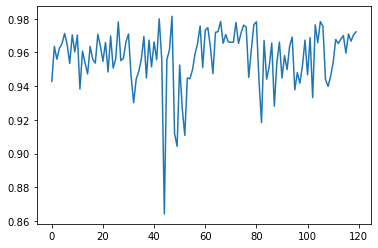

In [24]:
dice=np.asarray(dice)
print(np.mean(dice))
plt.plot(dice) #'Test Dice coefficient'
plt.show()